In [ ]:
# torch

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
import torch.optim as optim
# utils


from PIL import Image

from sklearn.model_selection import train_test_split


In [2]:
import torch
from glob import glob
import os
import random

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised"  # Update the dataset path to point to the single folder
image_size = (224, 224)
num_classes = 2

# Get all image paths from both folders (normal and stroke)
normal_image_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_image_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))

# Combine the paths and shuffle them
image_paths = normal_image_paths + stroke_image_paths
random.shuffle(image_paths)

# Split the image paths into train and test sets
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


cuda
Total images: 2501
Training set size: 2000
Testing set size: 501


In [3]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [5]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## CNN

In [10]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)


Epoch 0,   Train Loss: 0.3067, Train Accuracy: 86.10%
Eval Loss: 0.8945, Eval Accuracy: 66.00%
######################################################################
Epoch 1,   Train Loss: 0.3020, Train Accuracy: 86.35%
Eval Loss: 0.3190, Eval Accuracy: 84.00%
######################################################################
Epoch 2,   Train Loss: 0.2823, Train Accuracy: 86.55%
Eval Loss: 0.2640, Eval Accuracy: 88.40%
######################################################################
Epoch 3,   Train Loss: 0.2774, Train Accuracy: 87.20%
Eval Loss: 0.3261, Eval Accuracy: 84.80%
######################################################################
Epoch 4,   Train Loss: 0.2653, Train Accuracy: 87.60%
Eval Loss: 0.3601, Eval Accuracy: 81.60%
######################################################################
Epoch 5,   Train Loss: 0.2385, Train Accuracy: 89.65%
Eval Loss: 0.4340, Eval Accuracy: 80.00%
######################################################################
Epoc

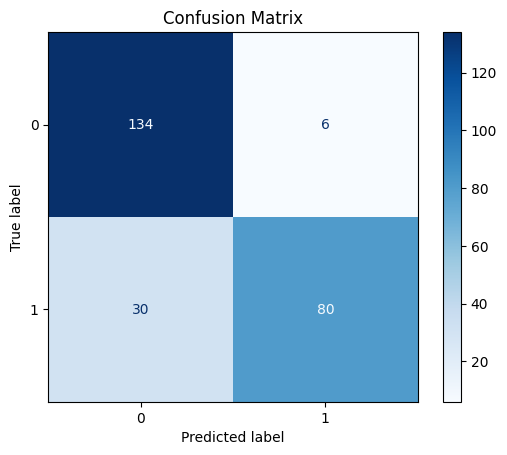

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       140
           1       0.93      0.73      0.82       110

    accuracy                           0.86       250
   macro avg       0.87      0.84      0.85       250
weighted avg       0.87      0.86      0.85       250



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming these lists are defined somewhere in your code
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_score = float("inf")
n_epochs = 10
tolerance = 0

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device) 
            labels = batch[1].to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(true_labels, preds))


In [16]:
import torch
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model class (same as the one used during training)
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the trained model
model = MyModel(num_classes=2)
model.load_state_dict(torch.load("model_9.pt"))  # Make sure the model path is correct
model = model.to(device)
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Helper function to map the prediction to label
def map_prediction_to_label(prediction):
    label_mapping = {0: "Normal", 1: "Stroke"}
    return label_mapping.get(prediction, "Unknown")

# Example usage
image_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal/100 (10).jpg"  # Replace with your image path
prediction = predict_image(image_path)
predicted_label = map_prediction_to_label(prediction)

print(f"The predicted label for the image is: {predicted_label}")


The predicted label for the image is: Normal


# MobileNet

Epoch 1: Train Loss: 0.5698, Train Acc: 69.55%, Val Loss: 0.4434, Val Acc: 77.60%
Epoch 2: Train Loss: 0.4284, Train Acc: 79.30%, Val Loss: 0.3267, Val Acc: 82.40%
Epoch 3: Train Loss: 0.3518, Train Acc: 84.40%, Val Loss: 0.3135, Val Acc: 85.60%
Epoch 4: Train Loss: 0.3126, Train Acc: 86.00%, Val Loss: 0.3929, Val Acc: 82.80%
Epoch 5: Train Loss: 0.2504, Train Acc: 89.45%, Val Loss: 0.2650, Val Acc: 88.00%
Epoch 6: Train Loss: 0.1953, Train Acc: 92.00%, Val Loss: 0.3096, Val Acc: 87.20%
Epoch 7: Train Loss: 0.1903, Train Acc: 92.35%, Val Loss: 0.3040, Val Acc: 88.00%
Epoch 8: Train Loss: 0.1535, Train Acc: 93.85%, Val Loss: 0.2919, Val Acc: 86.40%
Epoch 9: Train Loss: 0.1202, Train Acc: 95.35%, Val Loss: 0.2633, Val Acc: 91.60%
Epoch 10: Train Loss: 0.1259, Train Acc: 94.90%, Val Loss: 0.2291, Val Acc: 92.40%


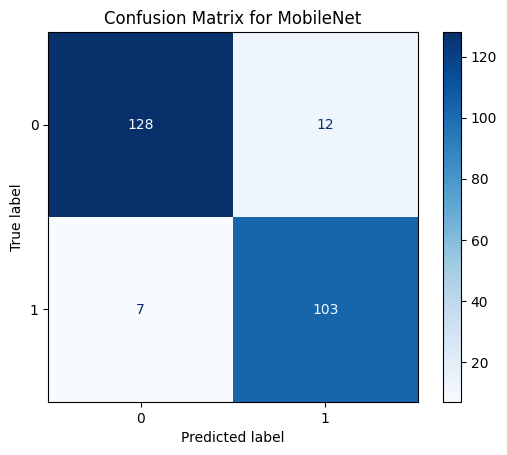

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       140
           1       0.90      0.94      0.92       110

    accuracy                           0.92       250
   macro avg       0.92      0.93      0.92       250
weighted avg       0.93      0.92      0.92       250



In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loaders as previously defined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetModel(num_classes=2).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "mobilenet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MobileNet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


In [23]:
import torch
from torchvision import transforms
from PIL import Image
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model class (same as the one used during training)
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Load the trained model
model = MobileNetModel(num_classes=2)
model.load_state_dict(torch.load("mobilenet.pt"))
model = model.to(device)
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Helper function to map the prediction to label
def map_prediction_to_label(prediction):
    label_mapping = {0: "Normal", 1: "Stroke"}
    return label_mapping.get(prediction, "Unknown")

# Example usage
image_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal/100 (9).jpg"
prediction = predict_image(image_path)
predicted_label = map_prediction_to_label(prediction)

print(f"The predicted label for the image is: {predicted_label}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The predicted label for the image is: Normal


# Resnet model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


Epoch 1: Train Loss: 0.6197, Train Acc: 66.00%, Val Loss: 0.6179, Val Acc: 69.20%
Epoch 2: Train Loss: 0.4734, Train Acc: 76.20%, Val Loss: 0.3605, Val Acc: 83.60%
Epoch 3: Train Loss: 0.3796, Train Acc: 83.00%, Val Loss: 0.3186, Val Acc: 88.40%
Epoch 4: Train Loss: 0.3411, Train Acc: 84.70%, Val Loss: 0.5333, Val Acc: 75.20%
Epoch 5: Train Loss: 0.3094, Train Acc: 87.40%, Val Loss: 0.2601, Val Acc: 87.60%
Epoch 6: Train Loss: 0.2633, Train Acc: 89.70%, Val Loss: 0.5777, Val Acc: 78.40%
Epoch 7: Train Loss: 0.2097, Train Acc: 91.15%, Val Loss: 0.2520, Val Acc: 87.20%
Epoch 8: Train Loss: 0.2388, Train Acc: 89.95%, Val Loss: 0.3615, Val Acc: 84.80%
Epoch 9: Train Loss: 0.1824, Train Acc: 93.55%, Val Loss: 0.2860, Val Acc: 91.20%
Epoch 10: Train Loss: 0.1638, Train Acc: 93.00%, Val Loss: 0.1905, Val Acc: 93.60%


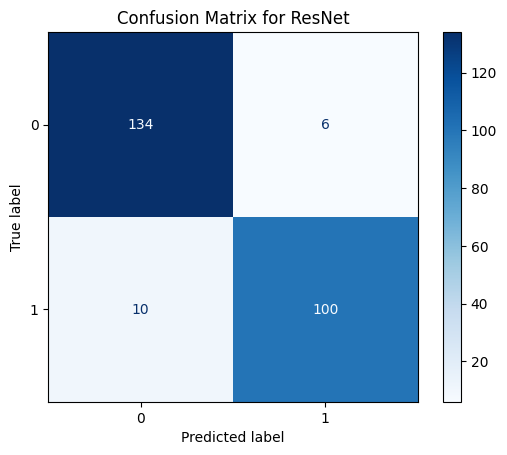

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       140
           1       0.94      0.91      0.93       110

    accuracy                           0.94       250
   macro avg       0.94      0.93      0.93       250
weighted avg       0.94      0.94      0.94       250



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loaders as previously defined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetModel(num_classes=2).to(device)  # Adjust num_classes accordingly
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "resnet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for ResNet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


In [25]:
import torch
from torchvision import transforms
from PIL import Image
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model class (same as the one used during training)
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Load the trained model
model = ResNetModel(num_classes=2)
model.load_state_dict(torch.load("resnet.pt"))
model = model.to(device)
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Helper function to map the prediction to label
def map_prediction_to_label(prediction):
    label_mapping = {0: "Normal", 1: "Stroke"}
    return label_mapping.get(prediction, "Unknown")

# Example usage
image_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke/58 (30).jpg"  # Replace with your image path
prediction = predict_image(image_path)
predicted_label = map_prediction_to_label(prediction)

print(f"The predicted label for the image is: {predicted_label}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The predicted label for the image is: Normal
